## Code to reproduce results and figures in (McFall 2022)
## To run just simply choose "Run All Cells"

In [1]:
#Import libraries you will need (along with some plot magic for notebooks)
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import pickle
import synergy
import pandas as pd
import plotly
import copy

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import ticker

## Dose response CTX + AMG-510, code to produce Figure 2B-E

In [3]:
#Function defining RAS model with G12Ci
def ras_wt_12i(kd_gdp=1.1e-4,ka_gdp=2.3e6,kd_gdp_mut=1.1e-4,ka_gdp_mut=2.3e6,
               kd_gtp=2.5e-4,ka_gtp=2.2e6,kd_gtp_mut=2.5e-4,ka_gtp_mut=2.2e6,
               kcat_gdp=3.9,Km_gdp=3.86e-4,Km_gtp=3e-4,#kcat_gtp=0.72
               kcat_gdp_mut=3.9,Km_gdp_mut=3.86e-4,Km_gtp_mut=3e-4,#kcat_gtp_mut=0.72
               k_hyd=3.5e-4,k_hyd_mut=3.5e-4,k_cat=5.4,Km=2.3e-7,k_cat_mut=5.4,Km_mut=2.3e-7,
               ka_eff=4.5e7,kd_eff=3.6,ka_eff_mut=4.5e7,kd_eff_mut=3.6,D=250,
               k_deg=8e-6,
               ka_drug=76,kd_gdp_SII=1.1e-4,ka_gdp_SII=2.3e6,
               SII_PI0=0,Ras_GDP_SII_mut0=0,Ras_nf_SII_mut0=0,
               GEF=2e-10*5,GAP=6e-11,GTP=1.8e-4,GDP=1.8e-5,
               Ras_GTP0=0,Ras_GDP0=4e-7,Ras_nf0=0,ras_wt=4e-7,ras_mut=4e-7,
               Eff0=4e-7,Ras_GTP_Eff0=0,Ras_GTP_mut0=0,
               Ras_GDP_mut0=0,Ras_nf_mut0=0,Ras_GTP_Eff_mut0=0,
               t_end=100000,dt=1.0):
    
    #Enforcing detailed balance
    kcat_gtp = (ka_gdp*GDP*kd_gtp/(kd_gdp*ka_gtp*GTP))*(kcat_gdp*Km_gtp/Km_gdp)
    kcat_gtp_mut = (ka_gdp_mut*GDP*kd_gtp_mut/(kd_gdp_mut*ka_gtp_mut*GTP))*(kcat_gdp_mut*Km_gtp_mut/Km_gdp_mut)
    #print(kcat_gtp,kcat_gtp_mut)
    
    #Production and degredation terms
    k_prod = k_deg*(ras_wt)
    k_prod_mut = k_deg*(ras_mut)
    #print(k_prod,k_prod_mut)
    
    def fmut(t,y): 
        Ras_GTP = y[0]
        Ras_GDP = y[1]
        Ras_nf = y[2]
        Eff = y[3]
        Ras_GTP_Eff = y[4]
        
        Ras_GTP_mut = y[5]
        Ras_GDP_mut = y[6]
        Ras_nf_mut = y[7]
        Ras_GTP_Eff_mut = y[8]
        
        SII_PI = y[9]
        Ras_GDP_SII_mut = y[10]
        Ras_nf_SII_mut = y[11]
        
        R1 = kd_gdp*Ras_GDP - ka_gdp*Ras_nf*GDP
        R1_mut = kd_gdp_mut*Ras_GDP_mut - ka_gdp_mut*Ras_nf_mut*GDP
        R2 = kd_gtp*Ras_GTP - ka_gtp*Ras_nf*GTP
        R2_mut = kd_gtp_mut*Ras_GTP_mut - ka_gtp_mut*Ras_nf_mut*GTP
        R3 = GEF*(kcat_gdp*Ras_GDP/(Km_gdp/D) - kcat_gtp*Ras_GTP/(Km_gtp/D))/(1+Ras_GDP/(Km_gdp/D) + Ras_GTP/(Km_gtp/D) + 
                                                                                 Ras_GDP_mut/(Km_gdp_mut/D) + Ras_GTP_mut/(Km_gtp_mut/D))
        R3_mut = GEF*(kcat_gdp_mut*Ras_GDP_mut/(Km_gdp_mut/D) - kcat_gtp_mut*Ras_GTP_mut/(Km_gtp_mut/D))/(1+Ras_GDP/(Km_gdp/D) + 
                                                                                                         Ras_GTP/(Km_gtp/D) +
                                                                                                         Ras_GDP_mut/(Km_gdp_mut/D) + 
                                                                                                         Ras_GTP_mut/(Km_gtp_mut/D))
        R4 = k_hyd*Ras_GTP
        R4_mut = k_hyd_mut*Ras_GTP_mut
        R5 = k_cat*GAP*Ras_GTP/((Km/D)*(1 + Ras_GTP_mut/(Km_mut/D)) + Ras_GTP)
        R5_mut = k_cat_mut*GAP*Ras_GTP_mut/((Km_mut/D)*(1 + Ras_GTP/(Km/D)) + Ras_GTP_mut)
        R6 = ka_eff*Ras_GTP*Eff - kd_eff*Ras_GTP_Eff
        R6_mut = ka_eff_mut*Ras_GTP_mut*Eff - kd_eff_mut*Ras_GTP_Eff_mut
        R7 = k_hyd*Ras_GTP_Eff
        R7_mut = k_hyd_mut*Ras_GTP_Eff_mut
        
        #Production and degredation
        R8 = k_prod - k_deg*Ras_nf
        R8_mut = k_prod_mut - k_deg*Ras_nf_mut
        R9 = -k_deg*Ras_GDP
        R9_mut = -k_deg*Ras_GDP_mut
        R10 = -k_deg*Ras_GTP
        R10_mut = -k_deg*Ras_GTP_mut
        R11 = -k_deg*Ras_GTP_Eff
        R11_mut = -k_deg*Ras_GTP_Eff_mut
        
        #Switch II pocket inhibitor reactions
        R15_mut = ka_drug*Ras_GDP_mut*SII_PI
        R16_mut = ka_drug*Ras_nf_mut*SII_PI
        
        R17_mut = -k_deg*Ras_GDP_SII_mut
        R18_mut = -k_deg*Ras_nf_SII_mut
        
        #R19_mut = kd_gdp_SII*Ras_GDP_SII_mut - ka_gdp_SII*Ras_nf_SII_mut*GDP
        R19_mut = kd_gdp_mut*Ras_GDP_SII_mut - ka_gdp_mut*Ras_nf_SII_mut*GDP
        
        res_0 = - R2 + R3 - R4 - R5 - R6 + R10 #WT RasGTP
        res_1 = - R1 - R3 + R4 + R5 + R7 + R9 #WT RasGDP
        res_2 = R1 + R2 + R8#WT RasNF
        res_3 = - R6 + R7 - R6_mut + R7_mut - R11 - R11_mut #Effector
        res_4 = R6 - R7 + R11 # WT RasGTP-Effector
        
        res_5 = - R2_mut + R3_mut - R4_mut - R5_mut - R6_mut + R10_mut #mut RasGTP
        res_6 = - R1_mut - R3_mut + R4_mut + R5_mut + R7_mut + R9_mut - R15_mut #mut RasGDP
        res_7 = R1_mut + R2_mut + R8_mut - R16_mut #mut RasNF
        res_8 = R6_mut - R7_mut + R11_mut #mut RasGTP-Effector
        
        res_9 = - R15_mut - R16_mut - R17_mut - R18_mut #SII_PI
        res_10 = R15_mut + R17_mut - R19_mut #Ras_GDP_SII_mut
        res_11 = R16_mut + R18_mut + R19_mut #Ras_nf_SII_mut
        
        return [res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,res_11]
    
    y0, t0 = [Ras_GTP0,Ras_GDP0,Ras_nf0,Eff0,Ras_GTP_Eff0,Ras_GTP_mut0,Ras_GDP_mut0,Ras_nf_mut0,Ras_GTP_Eff_mut0,
              SII_PI0,Ras_GDP_SII_mut0,Ras_nf_SII_mut0], 0
    r = scipy.integrate.ode(fmut).set_integrator('lsoda', method='bdf', with_jacobian=False)
    r.set_initial_value(y0, t0)
    
    t_vec = []
    Ras_GTP_vec = []
    Ras_GDP_vec = []
    Ras_nf_vec = []
    Eff_vec = []
    Ras_GTP_Eff_vec = []

    Ras_GTP_mut_vec = []
    Ras_GDP_mut_vec = []
    Ras_nf_mut_vec = []
    Ras_GTP_Eff_mut_vec = []
    
    SII_PI_vec = []
    Ras_GDP_SII_mut_vec = []
    Ras_nf_SII_mut_vec = []
    
    count = 1
    dmet = 1.0
    yprev = y0
    wtol = 1e-30
    while r.successful() and r.t < t_end and numpy.dot(dmet,dmet)>wtol:
        if r.t==0 or not count%100:
            t_vec.append(r.t)
            Ras_GTP_vec.append(r.y[0])
            Ras_GDP_vec.append(r.y[1])
            Ras_nf_vec.append(r.y[2])
            Eff_vec.append(r.y[3])
            Ras_GTP_Eff_vec.append(r.y[4])
            Ras_GTP_mut_vec.append(r.y[5])
            Ras_GDP_mut_vec.append(r.y[6])
            Ras_nf_mut_vec.append(r.y[7])
            Ras_GTP_Eff_mut_vec.append(r.y[8])
            SII_PI_vec.append(r.y[9])
            Ras_GDP_SII_mut_vec.append(r.y[10])
            Ras_nf_SII_mut_vec.append(r.y[11])
        r.integrate(r.t+dt)
        dmet = r.y - yprev
        #print(numpy.dot(dmet,dmet))
        yprev = r.y
        count=count+1
        
        if r.t>=t_end:
            print('Reached the end!')
        
    return [t_vec,Ras_GTP_vec,Ras_GDP_vec,Ras_nf_vec,Eff_vec,Ras_GTP_Eff_vec,
            Ras_GTP_mut_vec,Ras_GDP_mut_vec,Ras_nf_mut_vec,Ras_GTP_Eff_mut_vec,
            SII_PI_vec,Ras_GDP_SII_mut_vec,Ras_nf_SII_mut_vec]

In [4]:
#Initial concentrations and parameters
total_ras=4e-7
ras_wt=total_ras*0.75
ras_mut=total_ras*0.25
total_eff = 4e-7
GEF_base = 2e-10
#Default parameters
# 'kd_gdp':1.1e-4,'ka_gdp':2.3e6,'kd_gdp_mut':1.1e-4,'ka_gdp_mut':2.3e6,
# 'kd_gtp':2.5e-4,'ka_gtp':2.2e6,'kd_gtp_mut':2.5e-4,'ka_gtp_mut':2.2e6,
# 'kcat_gdp':3.9,'Km_gdp':3.86e-4,'kcat_gtp':0.72,'Km_gtp':3e-4,
# 'kcat_gdp_mut':3.9,'Km_gdp_mut':3.86e-4,'kcat_gtp_mut':0.72,'Km_gtp_mut':3e-4,
# 'k_hyd':3.5e-4,'k_hyd_mut':3.5e-4,'k_cat':5.4,'Km':2.3e-7,'k_cat_mut':5.4,'Km_mut':2.3e-7,
# 'ka_eff':4.5e7,'kd_eff':3.6,'ka_eff_mut':4.5e7,'kd_eff_mut':3.6,'D':250,
# k_deg=8e-6,
# ka_drug=76,kd_gdp_SII=1.1e-4,ka_gdp_SII=2.3e6,
# SII_PI0=0,Ras_GDP_SII_mut0=0,Ras_nf_SII_mut0=0,
# 'GEF':2e-10,'GAP':6e-11,'GTP':1.8e-4,'GDP':1.8e-5,
# 'Ras_GTP0':0,'Ras_GDP0':total_ras,'Ras_nf0':0,'ras_wt':total_ras,'ras_mut':0,
# 'Eff0':4e-7,'Ras_GTP_Eff0':0,'Ras_GTP_mut0':0,
# 'Ras_GDP_mut0':0,'Ras_nf_mut0':0,'Ras_GTP_Eff_mut0':0,
# 't_end':100000,'dt':1.0

In [5]:
#Biochemical parameters for mutant KRAS G12C
params_dic_2C = {'Km':2.3e-7,
                 'ka_drug':9900,
                 'kcat_gdp':3.9,
                 'kd_gdp_mut':1.1e-4,'ka_gdp_mut':2.3e6,
                 'kd_gtp_mut':2.5e-4,'ka_gtp_mut':2.2e6,
                 'k_hyd_mut':3.5e-4*(49.0/68),
                 'ka_eff_mut':4.5e7,'kd_eff_mut':3.6*(67.0/56),
                 'kcat_gdp_mut':3.9,'Km_gdp_mut':3.86e-4,'Km_gtp_mut':3e-4,#ka_gefd_mut=,ka_geft_mut=,'kcat_gtp_mut':0.72
                 'k_cat_mut':3.5e-4*(49.0/68),'Km_mut':2.3e-7*10,#ka_gap_mut=,
                 'k_deg':8e-6,
                 'Ras_GDP0':ras_wt,'Eff0':total_eff,'Ras_GDP_mut0':ras_mut,
                 'ras_wt':ras_wt,'ras_mut':ras_mut,
                 'GEF':GEF_base*11.91817654,'GAP':6e-11,
                 't_end':500000,'dt':1.0}

In [14]:
#Defining range of GEF concentration (modeling EGFRi) and G12Ci drug concentrations
GEF_base = 2e-10
a = numpy.zeros(41)
for aa in numpy.arange(41):
    a[aa]=(4.0/3)**aa
DrugDoses=(1e-10)*a

b = numpy.zeros(27)
for bb in numpy.arange(27):
    b[bb]=(1.1)**bb
    #b[bb]=(1.075)**bb
    
GEFvals=b*GEF_base

#print(DrugDoses, GEFvals, b)

In [7]:
%%time
#VARYING EGFRi and G12Ci
store_vec = []
for i,GEF_conc in enumerate(GEFvals):
    for j,Ci_conc in enumerate(DrugDoses):
        #G12C
        params_dic_2C['GEF'] = GEF_conc #GEF_conc
        params_dic_2C['SII_PI0'] = Ci_conc #Ci_conc
        [t_vec,Ras_GTP_vec,Ras_GDP_vec,Ras_nf_vec,Eff_vec,Ras_GTP_Eff_vec,
         Ras_GTP_mut_vec,Ras_GDP_mut_vec,Ras_nf_mut_vec,Ras_GTP_Eff_mut_vec,
         SII_PI_vec,Ras_GDP_SII_mut_vec,Ras_nf_SII_mut_vec] = ras_wt_12i(**params_dic_2C)
        
        store_vec_2C = [Ras_GTP_vec[-1],Ras_GDP_vec[-1],Ras_nf_vec[-1],Eff_vec[-1],Ras_GTP_Eff_vec[-1],
                        Ras_GTP_mut_vec[-1],Ras_GDP_mut_vec[-1],Ras_nf_mut_vec[-1],Ras_GTP_Eff_mut_vec[-1],
                        SII_PI_vec[-1],Ras_GDP_SII_mut_vec[-1],Ras_nf_SII_mut_vec[-1]]
    
        
        store_vec.append(store_vec_2C)

CPU times: user 4min 47s, sys: 5.88 s, total: 4min 52s
Wall time: 4min 52s


In [8]:
store_vec = numpy.array(store_vec)

plot_vec_bliss_wt = numpy.zeros([len(GEFvals),len(DrugDoses)])
plot_vec_bliss_mut = numpy.zeros([len(GEFvals),len(DrugDoses)])
plot_vec_bliss_tot = numpy.zeros([len(GEFvals),len(DrugDoses)])

plot_ras_gtp_wt = numpy.zeros([len(GEFvals),len(DrugDoses)])
plot_ras_gtp_mut = numpy.zeros([len(GEFvals),len(DrugDoses)])
plot_ras_gtp_tot = numpy.zeros([len(GEFvals),len(DrugDoses)])

count = 0
for i,GEF_conc in enumerate(GEFvals):
    for j,Ci_conc in enumerate(DrugDoses):
        ############
        ############    STANDARD: TOTAL RASGTP, WT MUTANT, from sweep
        ############
        zero_index1 = len(DrugDoses)*(len(GEFvals)-1)
        wt_ras_gtp_wt = (store_vec[zero_index1,0]+store_vec[zero_index1,4])#/total_ras
        wt_ras_gtp_mut = (store_vec[zero_index1,5]+store_vec[zero_index1,8])#/total_ras
        wt_ras_gtp_tot = wt_ras_gtp_wt + wt_ras_gtp_mut
                
        zero_index2 =  i*len(DrugDoses)
        egfri_alone_wt = 1 - (store_vec[zero_index2,0]+store_vec[zero_index2,4])/wt_ras_gtp_wt
        egfri_alone_mut = 1 - (store_vec[zero_index2,5]+store_vec[zero_index2,8])/wt_ras_gtp_mut
        egfri_alone_tot = 1 - (store_vec[zero_index2,0]+store_vec[zero_index2,4]+store_vec[zero_index2,5]+store_vec[zero_index2,8])/wt_ras_gtp_tot
        
        zero_index3 = zero_index1 + j
        g12ci_alone_wt = 1 - (store_vec[zero_index3,0]+store_vec[zero_index3,4])/wt_ras_gtp_wt
        g12ci_alone_mut = 1 - (store_vec[zero_index3,5]+store_vec[zero_index3,8])/wt_ras_gtp_mut
        g12ci_alone_tot = 1 - (store_vec[zero_index3,0]+store_vec[zero_index3,4]+store_vec[zero_index3,5]+store_vec[zero_index3,8])/wt_ras_gtp_tot
        
        combo_wt = 1 - (store_vec[count,0]+store_vec[count,4])/wt_ras_gtp_wt
        combo_mut = 1 - (store_vec[count,5]+store_vec[count,8])/wt_ras_gtp_mut
        combo_tot = 1 - (store_vec[count,0]+store_vec[count,4]+store_vec[count,5]+store_vec[count,8])/wt_ras_gtp_tot
        
        plot_vec_bliss_wt[i,j] = combo_wt - (egfri_alone_wt + g12ci_alone_wt - egfri_alone_wt*g12ci_alone_wt)
        plot_vec_bliss_mut[i,j] = combo_mut - (egfri_alone_mut + g12ci_alone_mut - egfri_alone_mut*g12ci_alone_mut)
        plot_vec_bliss_tot[i,j] = combo_tot - (egfri_alone_tot + g12ci_alone_tot - egfri_alone_tot*g12ci_alone_tot)
        
        plot_ras_gtp_wt[i,j] = store_vec[count,0]+store_vec[count,4]
        plot_ras_gtp_mut[i,j] = store_vec[count,5]+store_vec[count,8]
        plot_ras_gtp_tot[i,j] = store_vec[count,0]+store_vec[count,4]+store_vec[count,5]+store_vec[count,8]
        
        count = count + 1

In [9]:
def make_heatmap(vec):
    sub1 = 0
    sub2 = 21
    vecx = DrugDoses
    vecy = GEFvals

    #vec = plot_vec_bliss_tot*100

    fig, ax = plt.subplots()
    im = ax.imshow(numpy.flipud(vec),interpolation='none',cmap='jet')#,vmin=-0.002,vmax=0.25)

    # We want to show all ticks...
    ax.set_xticks(numpy.arange(len(vecx),step=2))
    ax.set_yticks(numpy.arange(len(vecy),step=2)[::-1])
    # ... and label them with the respective list entries
    ax.set_xticklabels(numpy.round(vecx[::2],4))
    ax.set_yticklabels(numpy.round(vecy[::2],4))

    ax.set_xlabel('G12Ci')
    ax.set_ylabel('EGFRi')

    cbar = ax.figure.colorbar(im, ax=ax)

    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=20)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #ax.set_title("Total Bliss Synergy Score RasGTP")
    plt.axis('off')

    fig.tight_layout()

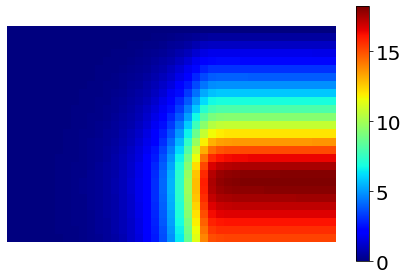

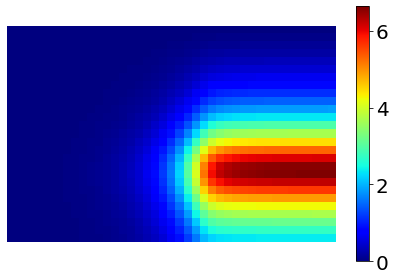

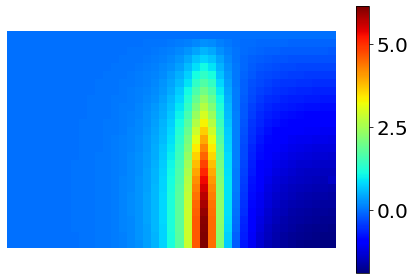

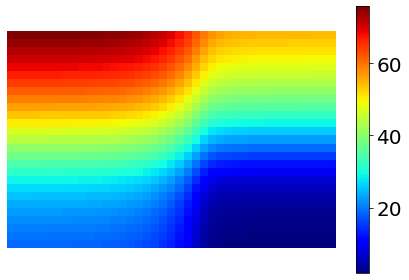

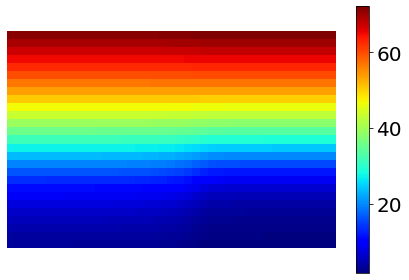

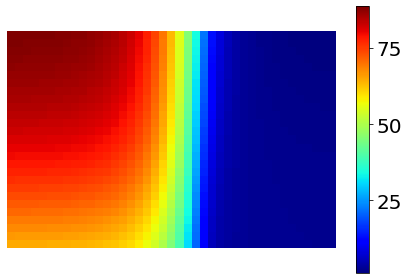

In [10]:
vec_list = [plot_vec_bliss_tot*100,plot_vec_bliss_wt*100,plot_vec_bliss_mut*100,
           plot_ras_gtp_tot*100/total_ras,plot_ras_gtp_wt*100/ras_wt,plot_ras_gtp_mut*100/ras_mut]
for vec in vec_list:
    make_heatmap(vec)

## Comparing ARS-853 and AMG-510, code to produce Supplementary Figure 2

In [11]:
%%time
#VARYING G12Ci
#AMG-510
store_vec2 = []
for j,Ci_conc in enumerate(DrugDoses):
    #G12C
    params_dic_2C['GEF'] = GEFvals[-1] #GEF_conc ##STANDARD
    params_dic_2C['SII_PI0'] = Ci_conc #Ci_conc
    [t_vec,Ras_GTP_vec,Ras_GDP_vec,Ras_nf_vec,Eff_vec,Ras_GTP_Eff_vec,
     Ras_GTP_mut_vec,Ras_GDP_mut_vec,Ras_nf_mut_vec,Ras_GTP_Eff_mut_vec,
     SII_PI_vec,Ras_GDP_SII_mut_vec,Ras_nf_SII_mut_vec] = ras_wt_12i(**params_dic_2C)

    store_vec_2C = [Ras_GTP_vec[-1],Ras_GDP_vec[-1],Ras_nf_vec[-1],Eff_vec[-1],Ras_GTP_Eff_vec[-1],
                    Ras_GTP_mut_vec[-1],Ras_GDP_mut_vec[-1],Ras_nf_mut_vec[-1],Ras_GTP_Eff_mut_vec[-1],
                    SII_PI_vec[-1],Ras_GDP_SII_mut_vec[-1],Ras_nf_SII_mut_vec[-1]]

    store_vec2.append(store_vec_2C)

CPU times: user 13.8 s, sys: 350 ms, total: 14.2 s
Wall time: 14.2 s


In [12]:
%%time
#VARYING G12Ci
#ARS-853
params_dic_2C['ka_drug']= 76
params_dic_2C['t_end']= 700000
store_vec_with_deg = []
for j,Ci_conc in enumerate(DrugDoses):
    #G12C
    params_dic_2C['GEF'] = GEFvals[-1] #GEF_conc ##STANDARD
    params_dic_2C['SII_PI0'] = Ci_conc #Ci_conc
    [t_vec,Ras_GTP_vec,Ras_GDP_vec,Ras_nf_vec,Eff_vec,Ras_GTP_Eff_vec,
     Ras_GTP_mut_vec,Ras_GDP_mut_vec,Ras_nf_mut_vec,Ras_GTP_Eff_mut_vec,
     SII_PI_vec,Ras_GDP_SII_mut_vec,Ras_nf_SII_mut_vec] = ras_wt_12i(**params_dic_2C)

    store_vec_2C = [Ras_GTP_vec[-1],Ras_GDP_vec[-1],Ras_nf_vec[-1],Eff_vec[-1],Ras_GTP_Eff_vec[-1],
                    Ras_GTP_mut_vec[-1],Ras_GDP_mut_vec[-1],Ras_nf_mut_vec[-1],Ras_GTP_Eff_mut_vec[-1],
                    SII_PI_vec[-1],Ras_GDP_SII_mut_vec[-1],Ras_nf_SII_mut_vec[-1]]

    store_vec_with_deg.append(store_vec_2C)

CPU times: user 1min 9s, sys: 1.68 s, total: 1min 10s
Wall time: 1min 10s


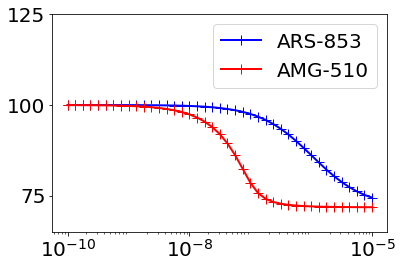

In [13]:
store_vec2 = numpy.array(store_vec2)
store_vec_with_deg = numpy.array(store_vec_with_deg)
resp_list = (store_vec2[:,0]+store_vec2[:,4]+store_vec2[:,5]+store_vec2[:,8])
resp_list = resp_list*100/max(resp_list)
resp_list_with_deg = (store_vec_with_deg[:,0]+store_vec_with_deg[:,4]+store_vec_with_deg[:,5]+store_vec_with_deg[:,8])
resp_list_with_deg = resp_list_with_deg*100/max(resp_list_with_deg)
plt.semilogx(DrugDoses,resp_list_with_deg,'b+-',label='ARS-853',linewidth=2,markersize=10)
plt.semilogx(DrugDoses,resp_list,'r+-',label='AMG-510',linewidth=2,markersize=10)
#plt.xlabel('G12Ci [M]')
#plt.ylabel('Total RasGTP [% of max]',fontsize=20)
plt.ylim([65,125])
plt.xticks([10**-10,10**-8,10**-5],size=20)#,fontweight='bold')
plt.yticks([75,100,125],size=20)

plt.legend(fontsize=20)